# ring model for SSD in neurons

In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.signal import resample
import matplotlib.pyplot as plt
import pandas as pd
import importlib

from C_module_interface import neuron_gill_ring_sim
from plot_module import plot_ODE, plot_gillespie

In [2]:
# ode model of SSD in neurons
def neuron_model(t, z):
    so_w, so_m, r1_w, r1_m, r2_w, r2_m, r3_w, r3_m, r4_w, r4_m, r5_w, r5_m, = z
    
    # birth reactions
    birth_soma_wt = 2*MU + C_B*(NSS_S-so_w-so_m*DELTA) 
    birth_soma_mt = 2*MU + C_B*(NSS_S-so_w-so_m*DELTA)
    
    return [so_w*(birth_soma_wt-GAMMA-MU) + r5_w*GAMMA, 
            so_m*(birth_soma_mt-GAMMA-MU) + r5_m*GAMMA, 
            r1_w*(-MU-GAMMA) + so_w*(GAMMA),
            r1_m*(-MU-GAMMA) + so_m*(GAMMA),
            r2_w*(-MU-GAMMA) + r1_w*(GAMMA),
            r2_m*(-MU-GAMMA) + r1_m*(GAMMA),
            r3_w*(-MU-GAMMA) + r2_w*(GAMMA),
            r3_m*(-MU-GAMMA) + r2_m*(GAMMA),
            r4_w*(-MU-GAMMA) + r3_w*(GAMMA),
            r4_m*(-MU-GAMMA) + r3_m*(GAMMA),
            r5_w*(-MU-GAMMA) + r4_w*(GAMMA),
            r5_m*(-MU-GAMMA) + r4_m*(GAMMA),
           ]

### Parameters of the simulation

In [8]:
## BIOLOGICAL PARAMETERS ##
MU = 0.07 # death rate
GAMMA = 0.05 # transport rate
DELTA = 0.5 # mutant deficiency
C_B = 0.1 # birth adaptibility constant
NSS_S = 400 # soma carrying capacity

## VARIABLE NAMES ##
VARS = ['so wt', 'so mt', 
        'r1 wt', 'r1 mt',
        'r2 wt', 'r2 mt',
        'r3 wt', 'r3 mt',
        'r4 wt', 'r4 mt',
        'r5 wt', 'r5 mt'
       ]

## COMPONENT NAMES ##
COMP = ['soma','r1','r2','r3','r4','r5',]

## SIMULATION PARAMETERS ##
MAX_T = 5000
TIME_POINTS = np.linspace(0, MAX_T, 500)
start_state = np.array([380, 40, 190, 20, 190, 20, 190, 20, 190, 20, 190, 20], dtype = np.int64)

## Deterministic simulation

In [4]:
sol = integrate.solve_ivp(neuron_model, [0, MAX_T], start_state, t_eval=TIME_POINTS, 
                          method = 'LSODA' # eq system is stiff, needs a solver that can handle such cases
                         )

results = sol.y

Final counts of mt and wt in each compartment:
so wt	380.196	
so mt	40.0206	
r1 wt	158.415	
r1 mt	16.6753	
r2 wt	66.0062	
r2 mt	6.948	
r3 wt	27.5026	
r3 mt	2.895	
r4 wt	11.4594	
r4 mt	1.2063	
r5 wt	4.7748	
r5 mt	0.5026	

Final effective population sizes in each compartment:
soma	400.2063	
r1	166.7526	
r2	69.4803	
r3	28.9501	
r4	12.0625	
r5	5.0261	


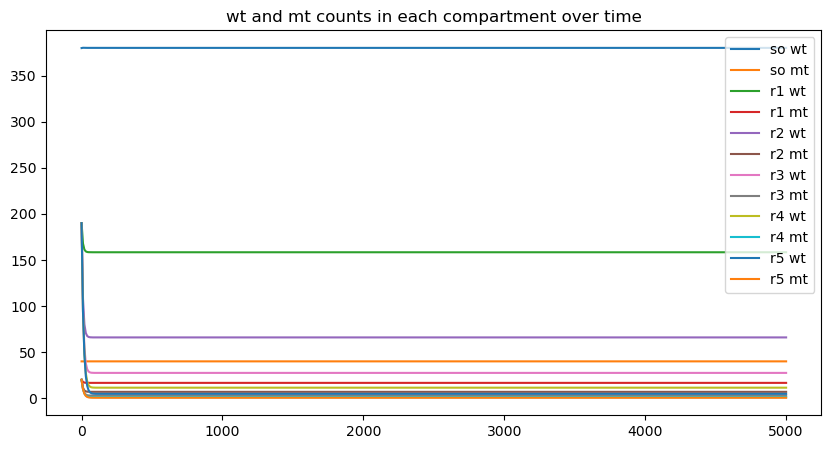

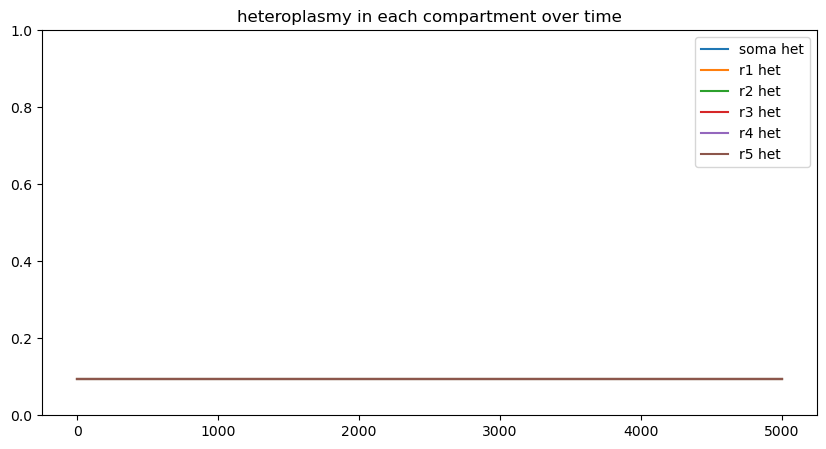

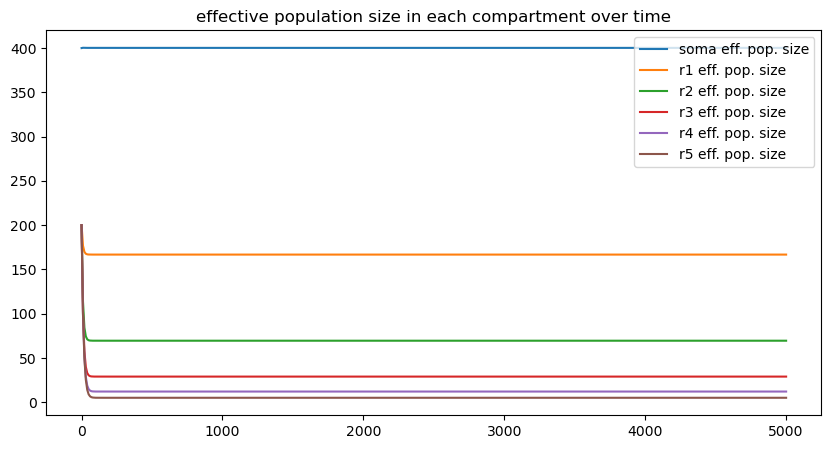

In [5]:
plot_ODE(results, TIME_POINTS, DELTA, VARS, COMP)

## Pooled results from Gillespie based simulation

In [6]:
REPLICATES = 10000
replicate_results = np.zeros((REPLICATES, N_VARS, TIME_POINTS.size), dtype = np.int64)

print('simulating...')
for i in range(REPLICATES):
    replicate_results[i, :, :] = np.swapaxes(neuron_gill_ring_sim(MU, GAMMA, DELTA, C_B, NSS_S, TIME_POINTS, start_state), 0, 1)
    print(f"{round(((i+1)/REPLICATES)*100, 2)}% completed  ", end = "\r")

simulating...


/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/plot_module.py:86: RuntimeWarning: invalid value encountered in true_divide
  het = np.nanmean(replicate_results[:,(i*2)+1,:]/(replicate_results[:,(i*2)+1,:]+replicate_results[:,i*2,:]), axis = 0)


Final mean counts of mt and wt in each compartment:
so wt	365.2185	
so mt	69.9431	
r1 wt	152.2303	
r1 mt	29.074	
r2 wt	63.4366	
r2 mt	12.1387	
r3 wt	26.5513	
r3 mt	5.0636	
r4 wt	10.9728	
r4 mt	2.104	
r5 wt	4.6014	
r5 mt	0.8868	

Final mean heteroplasmy in each compartment:
soma	0.0941	
r1	0.0942	
r2	0.0941	
r3	0.0941	
r4	0.0943	
r5	0.0946	

Final mean effective population sizes in each compartment:
soma	400.19	
r1	166.7673	
r2	69.506	
r3	29.0831	
r4	12.0248	
r5	5.0448	


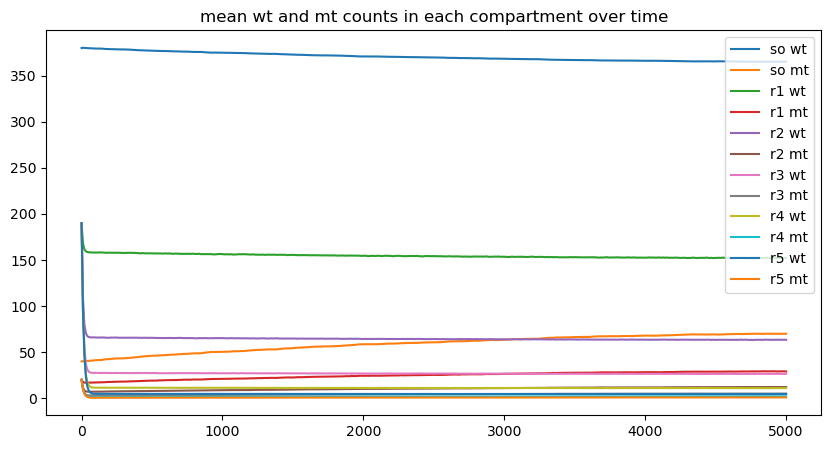

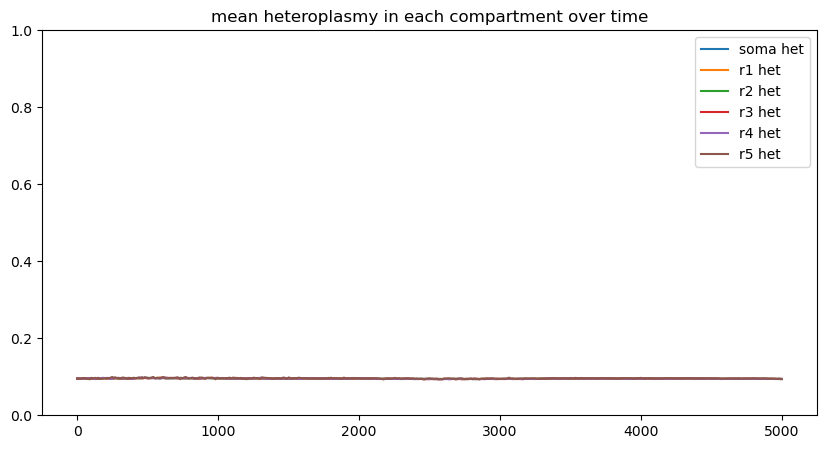

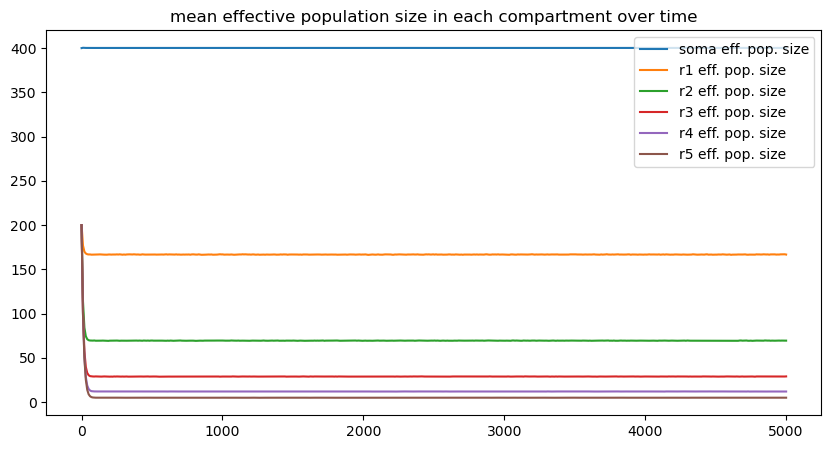

In [7]:
plot_gillespie(replicate_results, TIME_POINTS, DELTA, VARS, COMP)